In [1]:
import pandas as pd
#import nltk
from matplotlib import pyplot as plt
from scrape_data import *
from process_text import *
from helper import *

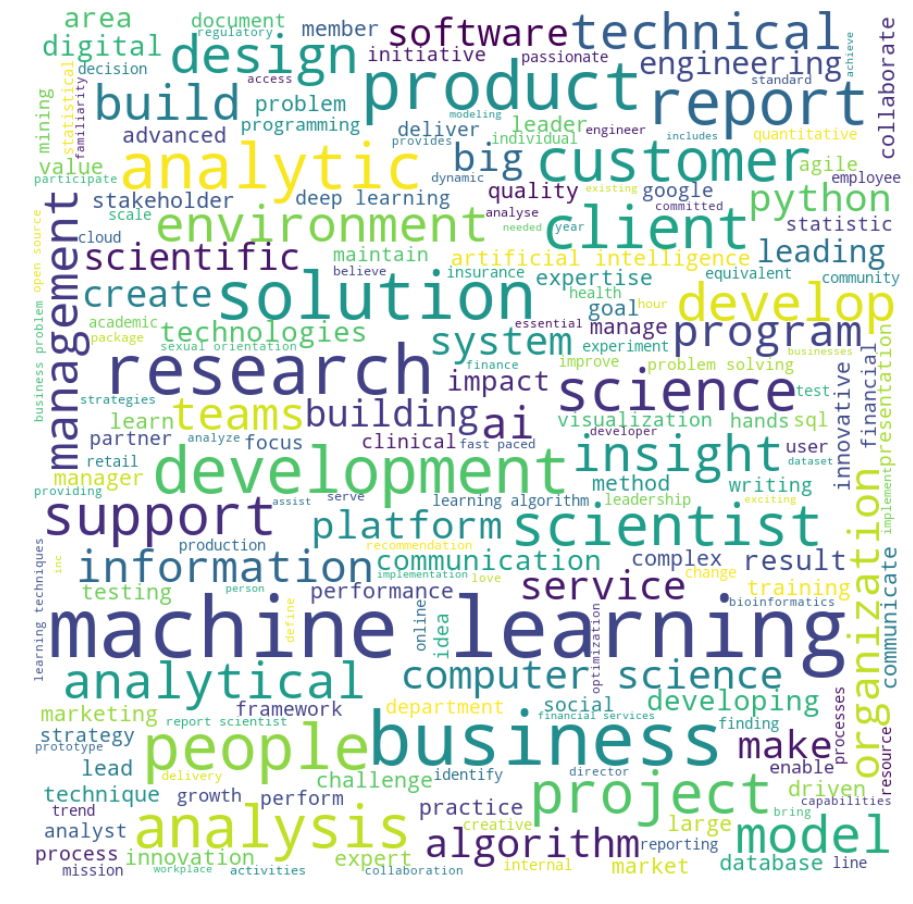

In [2]:
plot_profile('data scientist', max_words=200, first_n_postings=120)

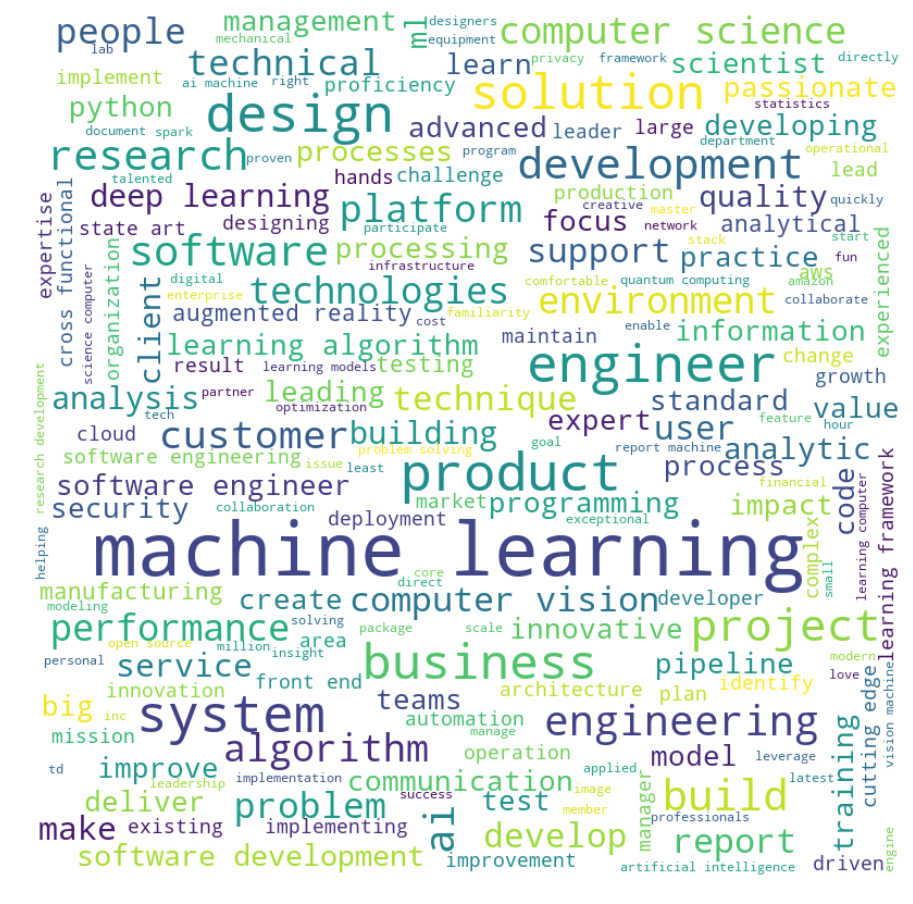

In [3]:
plot_profile('machine learning engineer', max_words=200, first_n_postings=120)

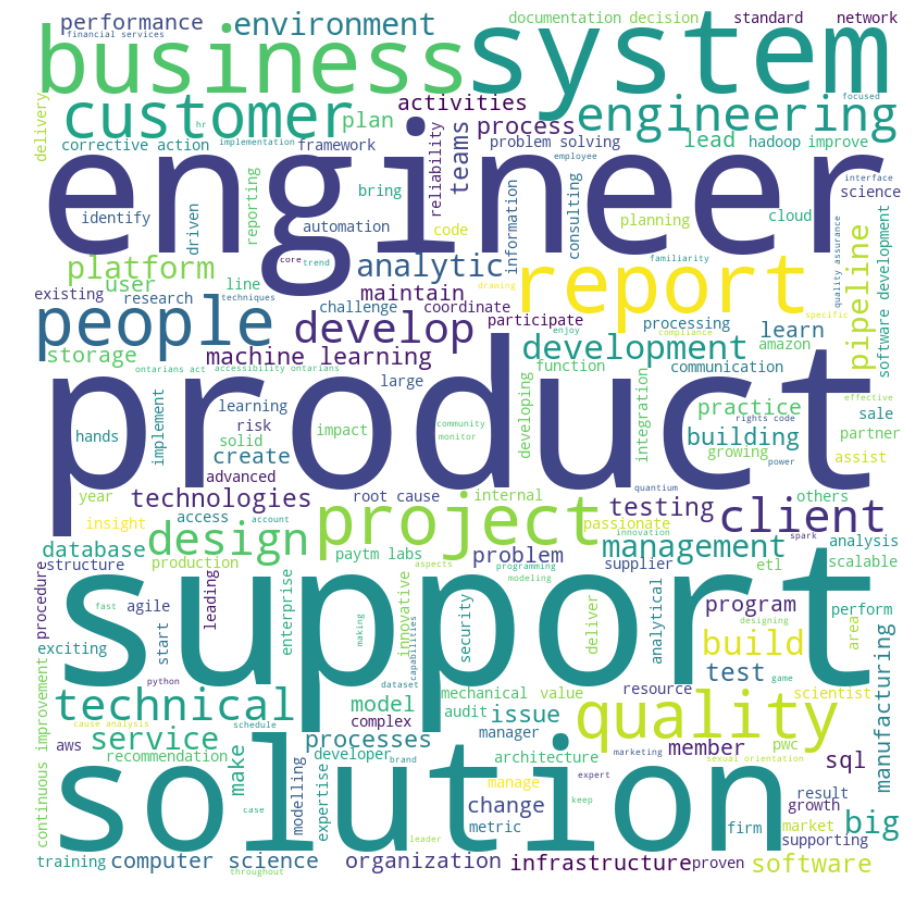

In [4]:
plot_profile('data engineer', max_words=200, first_n_postings=120)

In [5]:
df = pd.read_csv('skill_frequencies.csv')

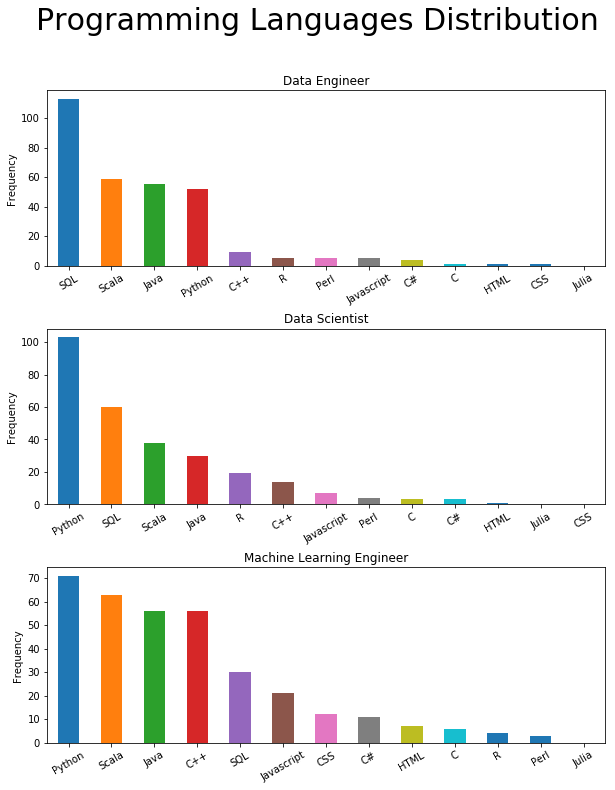

In [6]:
plot_skill(df, 'programming languages', save_figure=True)

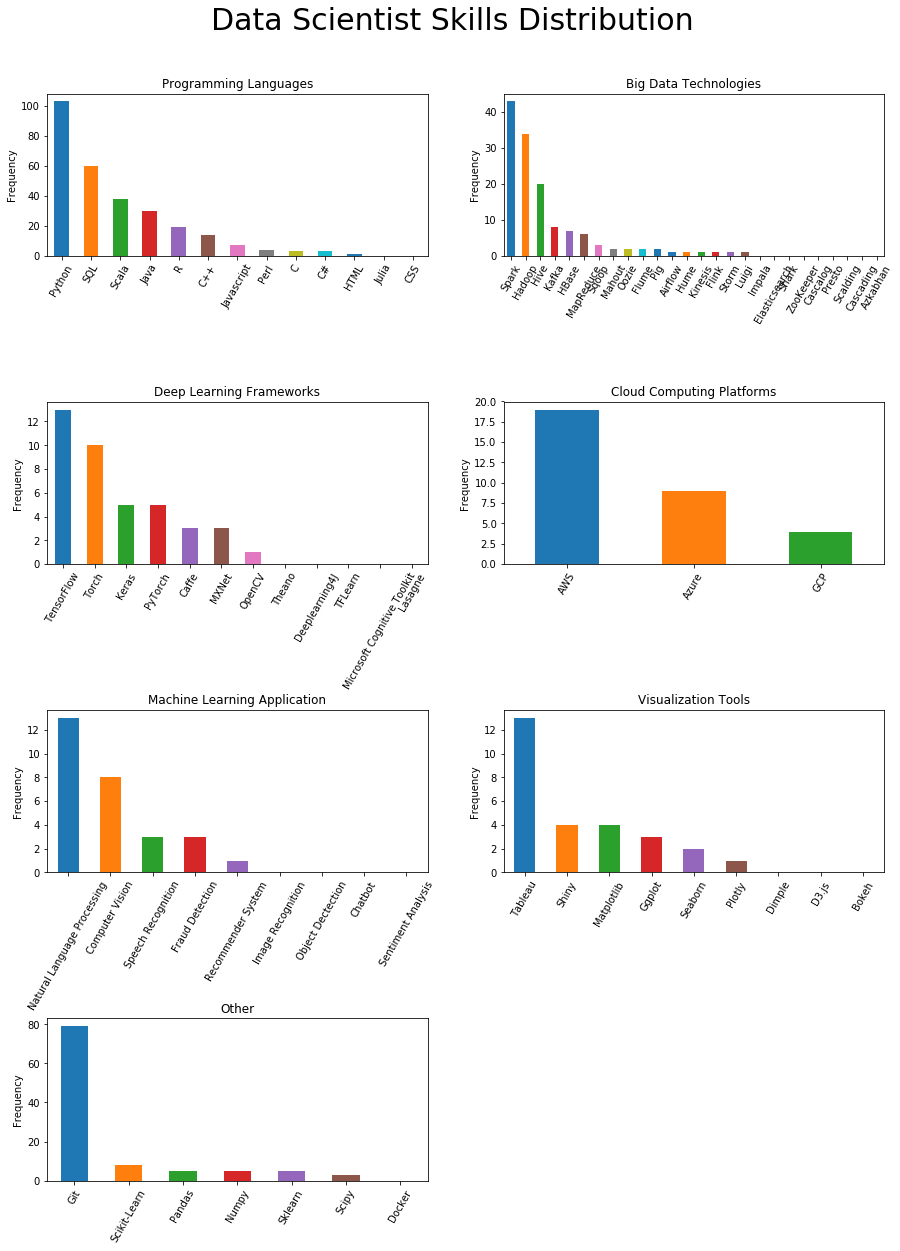

In [7]:
plot_title(df, 'data scientist', save_figure=True)

## Todo's
- readme, dependencies
- refactor notebook code
- confirm r's ranking
- get more data on indeed usa
- show word context
- docstring and comments
- OOP
- single responsiblity principle for functions
- assumptions and limitations (sample representative...)